In [56]:
import pandas as pd
import numpy as np
import sqlite3
import pickle
import datetime


import sys
import aiutils.aiutils as ai
import aiutils.aiutils_keras as ker
import aiutils.features_manager as feat
import aiutils.labels_manager as lab
import aiutils.ai_backtester as bt
import aiutils.preprocessing as pr
import talib as ta
import pandas_ta as ta
import matplotlib.pyplot as plt
from keras import backend as K

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, PReLU, ELU, ThresholdedReLU, Conv1D, MaxPooling1D, GlobalMaxPool1D, GlobalAveragePooling1D, LSTM, GRU, SimpleRNN, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

from preprocess import *

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

# Magic commands
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

pd.options.display.width=None

# Avoid scientific notation when printing numpy arrays in most cases
np.set_printoptions(suppress=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Création du modèle

In [57]:
### définition de la focal loss, peut être utilisée en dessous ###

def focal_loss(gamma, alpha):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss, axis=1)
    return focal_loss_fixed

In [63]:
# Si on a besoin de changer le format des données
X_train_reshaped = X_train 
y_train_reshaped = y_train
X_val_reshaped = X_val     

#les différents hyperparamètres d'entrainement (learning rate, optimizer, loss, etc...) peuvent être changés ici

learning_rate = 0.0001
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
loss = 'categorical_crossentropy'
epochs = 48
batch_size = 64
shuffle_during_fit = True
metric = ['accuracy']

tf.keras.utils.set_random_seed(seed)

In [64]:
# tous les modèles sont définis ici, déommenter le modèle que l'on shouaite utiliser

inputs = tf.keras.layers.Input(shape=(lookback,len(features)))

############################################################## CNN ###########################################################################
 
""" x = tf.keras.layers.Conv1D(64, 3, activation='tanh',input_shape=inputs.shape[1:], strides=1, padding='valid')(inputs)
x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
x= tf.keras.layers.Dropout(0)(x)

x = tf.keras.layers.Conv1D(128, 3, activation='tanh')(x)
x= tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Conv1D(64, 3, activation='tanh')(x)
x =  tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding='valid')(x)
x= tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv1D(128, 3, activation='relu',input_shape=inputs.shape[1:])(x)

x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs = inputs, outputs = outputs) """

############################################################## SIMPLE LSTM ###########################################################################

""" model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(Flatten())
model.add(Dense(2,activation = 'softmax')) """

############################################################### LOGISTIC REGRESSION ####################################################################

inputs = tf.keras.layers.Input(shape = X_train.shape[1:])
flatten = Flatten()(inputs)
outputs = tf.keras.layers.Dense(units = 2, activation = 'softmax')(flatten)
model = tf.keras.Model(inputs = inputs, outputs = outputs)

############################################################ Double-LSTM ##################################################################################
""" model = Sequential()


model.add(LSTM(128, return_sequences=True, input_shape=(16, 12))) 
model.add(BatchNormalization()) 

model.add(Dropout(0.3)) 

model.add(LSTM(64, return_sequences=False))  
model.add(BatchNormalization())  

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(2, activation='sigmoid')) """

####################################################################### ATTENTION LAYER #######################################################################################################################################

""" h = tf.keras.layers.LSTM(6, return_sequences = True)(inputs)
c = tf.concat([inputs, h] , axis = -1)

c = tf.keras.layers.Dense(7, activation = None)(c)
c = tf.keras.layers.Activation('tanh')(c)
a = tf.keras.layers.Dense(1, activation = None)(c)
b = tf.keras.layers.Activation('softmax')(a)
attinputs = tf.keras.layers.multiply([b,inputs])

x = tf.keras.layers.LSTM(32, return_sequences = True)(attinputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16,activation = 'relu')(x)
x = tf.keras.layers.Dense(8,activation = 'relu')(x)
outputs =  tf.keras.layers.Dense(2, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs) """

#######################################################################################################################################

model.summary()
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=False,expand_nested=True,dpi=96)
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metric)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 16, 12)]          0         
                                                                 
 flatten_11 (Flatten)        (None, 192)               0         
                                                                 
 dense_23 (Dense)            (None, 2)                 386       
                                                                 
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Entrainement du modèle

In [65]:
callbacks = []
save_best_model = ker.SaveBestModel(metric='val_accuracy',from_epoch=20)
print(save_best_model)
callbacks.append(save_best_model)
callbacks.append(ker.TrainingProgress())

history = model.fit(X_train_reshaped,y_train_reshaped,epochs=epochs,batch_size=batch_size,
                    shuffle=shuffle_during_fit,validation_data=(X_val_reshaped,y_val),callbacks=callbacks,
                    verbose = 0)

model.set_weights(save_best_model.best_weights)

Start Training
Epoch 0  220.85 ms - Epoch 1  62.92 ms - Estimated Training Time : 0:00:02.894280
Epochs:  4 (10%) 9 (20%) 14 (30%) 19 (40%) 23 (50%) 28 (60%) 33 (70%) 38 (80%) 43 (90%) 47 (100%) 
Best val_accuracy : 0.4692 on Epoch 22
Training Completed in : 0:00:03.074014


# Backtest

In [66]:
def ClassifierReport(x,y_true,model,history,save_best_model,batch_size=32):
    ker.plot_history(history.history)
    
    # Load best weights
    if save_best_model is not None:
        model.set_weights(save_best_model.best_weights)
    
    # Classification Report
    y_true = np.argmax(y_true,axis=1)
    
    y_pred = np.argmax(model.predict(x, batch_size=32),axis=1)
    cnf_matrix = confusion_matrix(y_true,y_pred)
    accuracy = round(accuracy_score(y_true,y_pred),5)
    precision, recall, fscore, support = precision_recall_fscore_support(y_true,y_pred)
    
    class_report = pd.DataFrame.from_dict({'precision': precision,
                                           'recall': recall,
                                           'f1-score': fscore,
                                           'support': support})
    
    
    print('Accuracy : {}'.format(accuracy))
    print(class_report)
    ker.plot_confusion_matrix_custom(cnf_matrix,classes=['down','up'])
    return accuracy, class_report

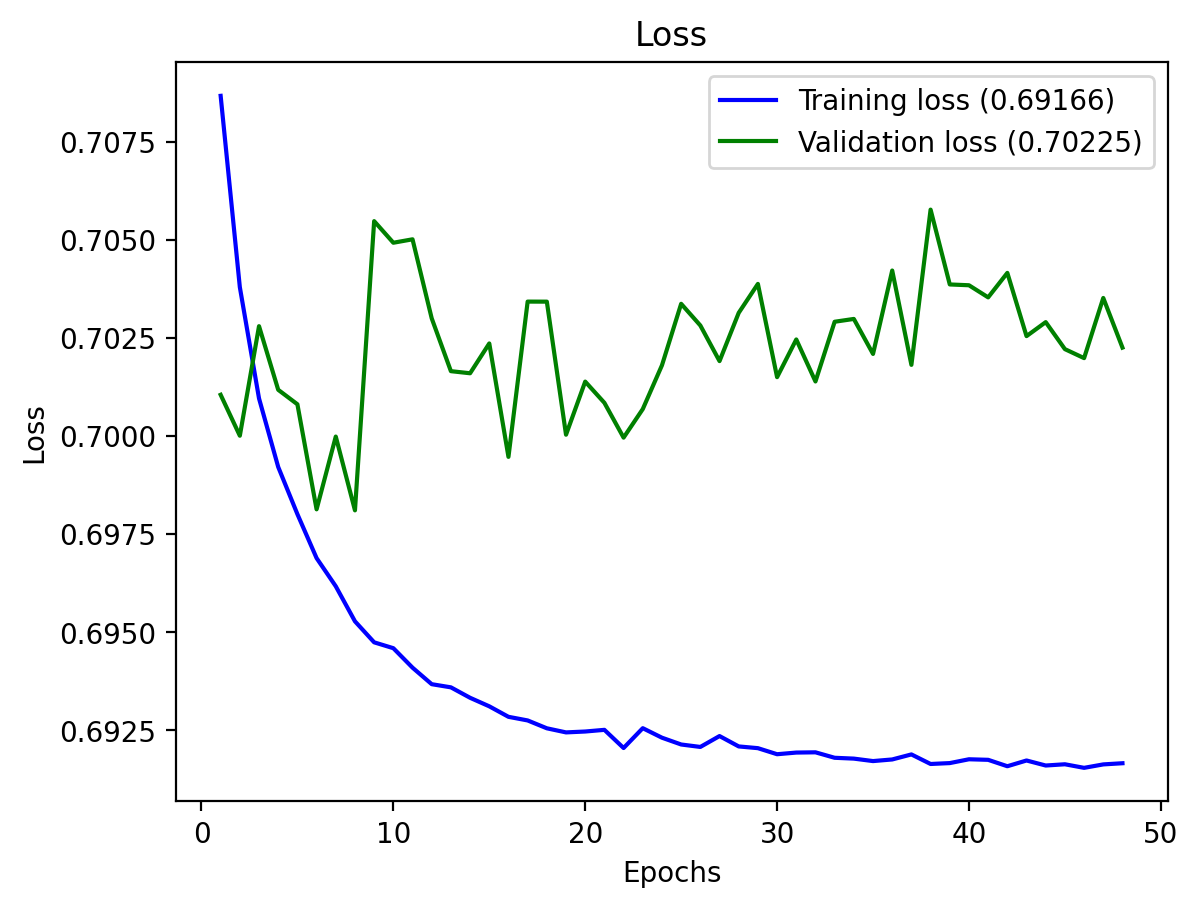

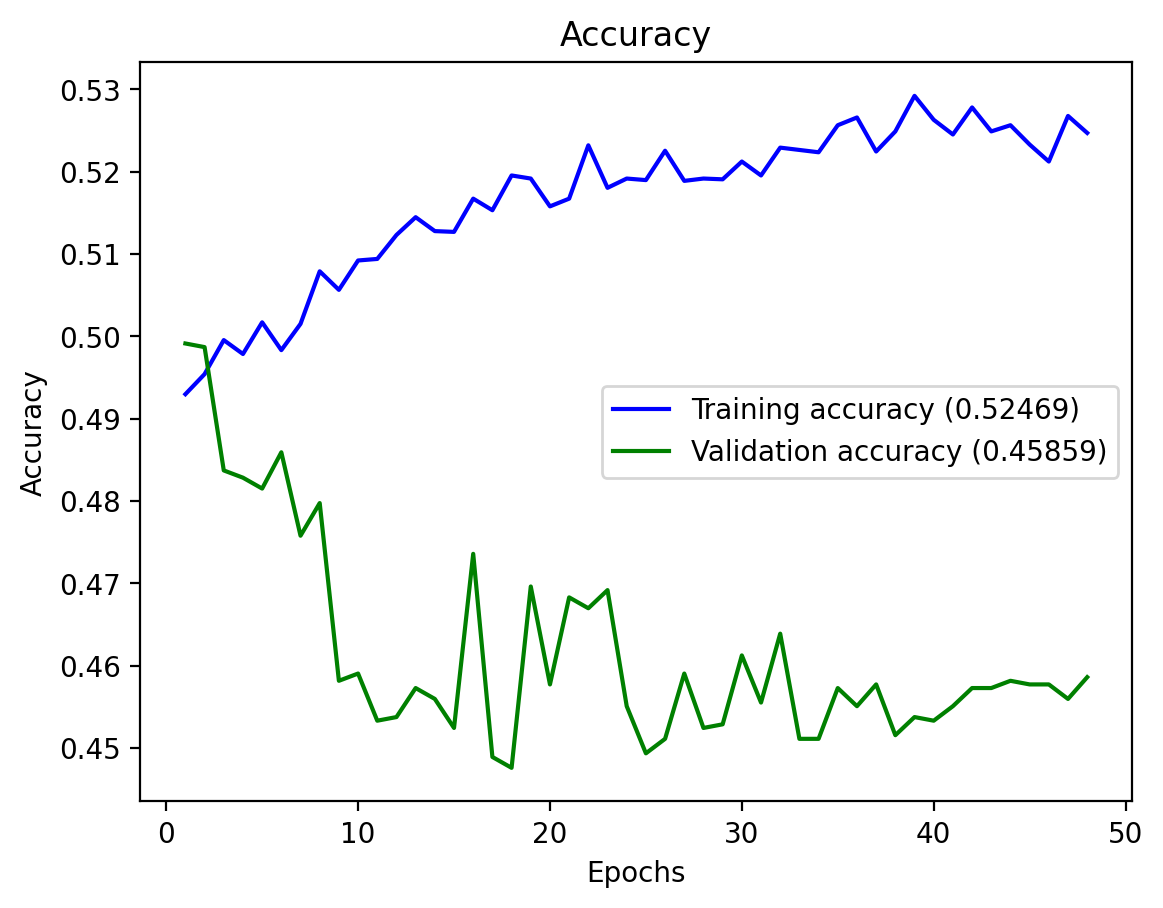

71/71 [==============================] - 0s 277us/step
Accuracy : 0.46916
   precision    recall  f1-score  support
0   0.506211  0.401808  0.448007     1217
1   0.441718  0.547009  0.488757     1053


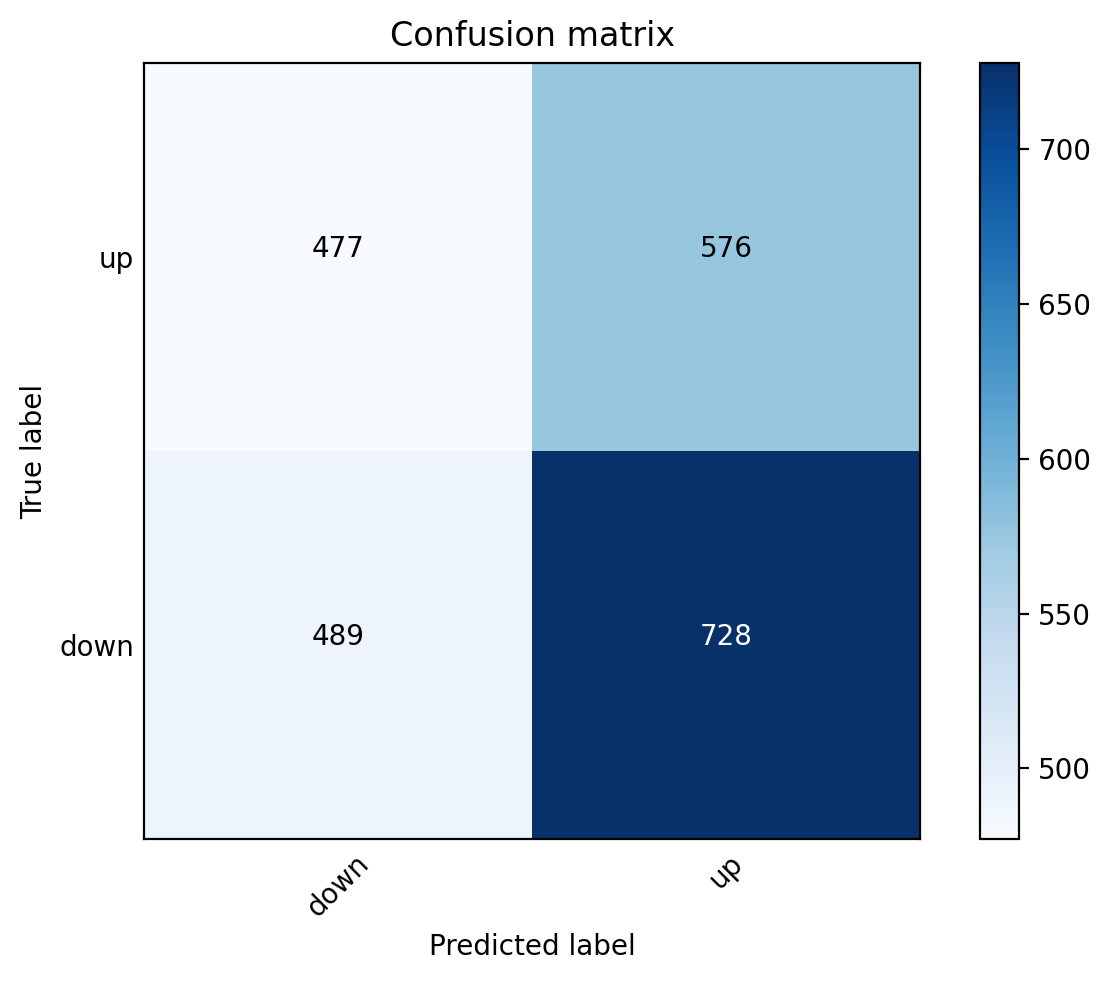

71/71 [==============================] - 0s 258us/step


### EURUSD Model V1 Strategy

CY

_2024-04-26 20:18:38_

#### Setup

,
symbol,EURUSD
timescale,Hourly
spread,0.00000
starting equity,"10,000"
from,2018-03-27 12:00:00
to,2021-09-24 16:00:00


---

#### Performance Report

,All,Long,Short
Net P&L,"-2,195.50","-3,189.30",993.80
Gross Profit,"48,171.00","26,287.30","21,883.70"
Gross Loss,"-50,366.50","-29,476.60","-20,889.90"
Profit Factor,0.96,0.89,1.05
Total # of Trades,"4,540.00","2,545.00","1,995.00"
Number Winning Trades,"2,210.00","1,205.00","1,005.00"
Number Losing Trades,"2,330.00","1,340.00",990.00
Percent Profitable,0.49,0.47,0.50
Avg Trade Win Loss,-0.48,-1.25,0.50
Avg Winning Trade,21.80,21.82,21.77


#### Performance/Risk Metrics

,,
slope,0.3482,
r2,0.2056,
stderr,0.0102,
quality ratio,7.0463,
Max Drawdown,4368.8,2020-03-19 00:00:00
Max Drawdown %,44.0 %,2020-03-19 00:00:00


#### Returns Metrics

,
Cumulative returns,-0.2195
Annual return,-0.0661
Average monthly return,-0.0035
Return Max Drawdown,-0.4338
MDD Recovery Period,263.0000
Longest Drawdown Period,775.0000
Mean daily loss,-0.0089
Worst daily loss,-0.0745
99% quantile daily loss,-0.0426
Worst monthly loss,-0.1688


#### Risk Adjusted Metrics

,
Sharpe,-0.3049
Sortino,-0.4386
Omega,0.9618
Calmar,-0.1523


#### Equity Curve

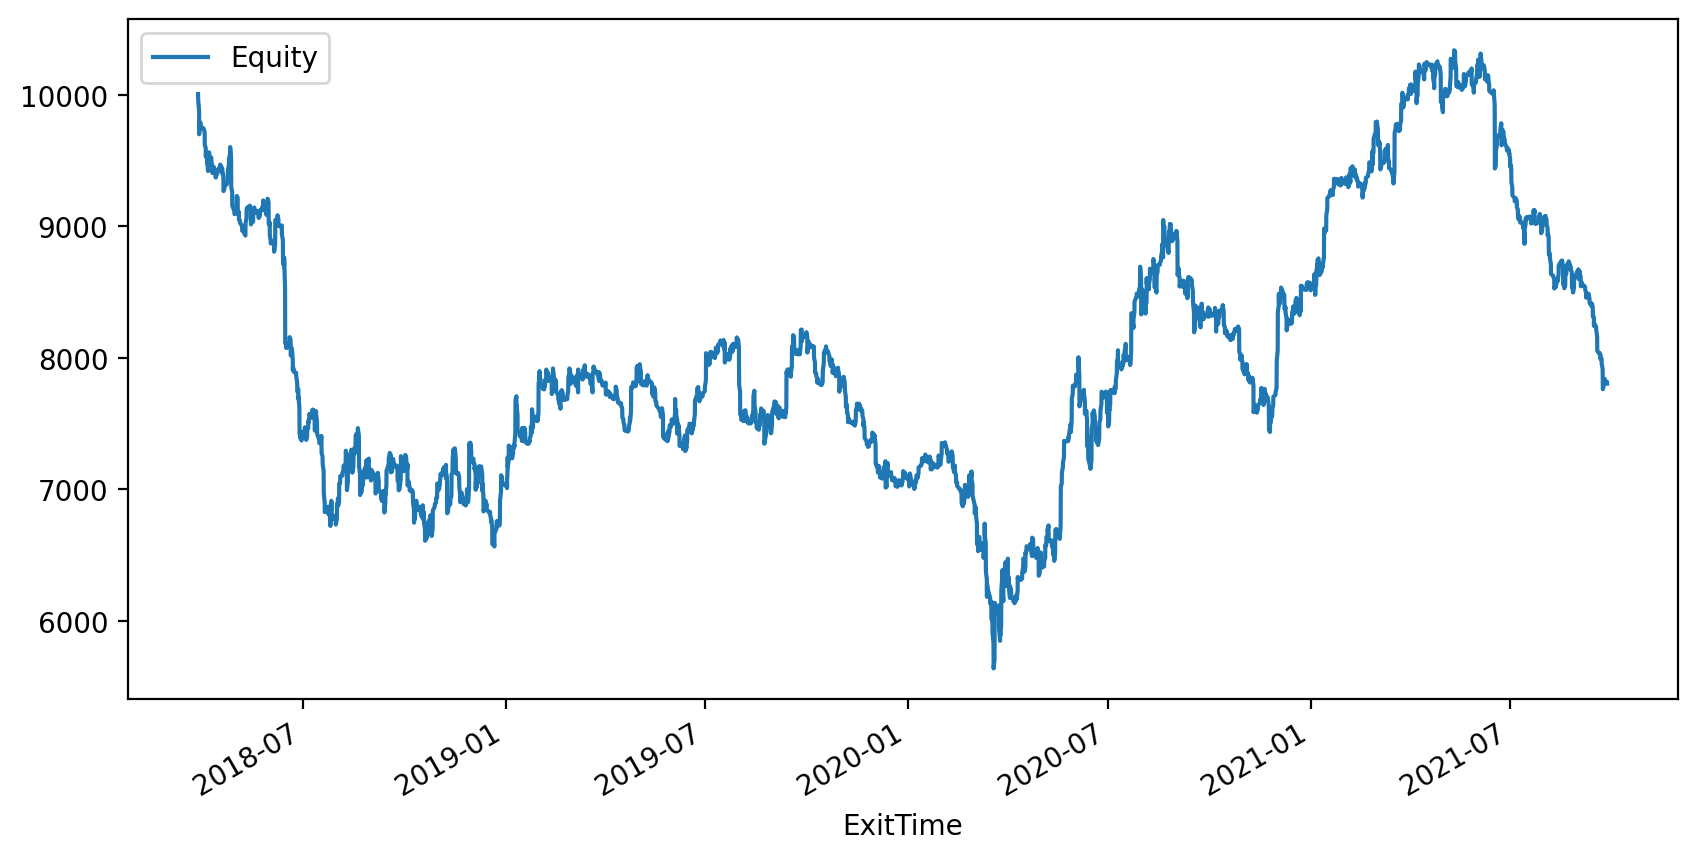

#### P&L Statistics

,Daily PL,Weekly PL,Monthly PL
count,910.00,183.00,43.00
mean,-2.41,-12.00,-51.06
std,97.37,226.33,534.24
min,-557.10,-889.70,"-1,542.60"
25%,-50.03,-145.85,-414.85
50%,-3.20,-9.70,-22.70
75%,45.77,119.15,234.70
max,360.60,743.00,"1,376.50"


#### Monthly Returns

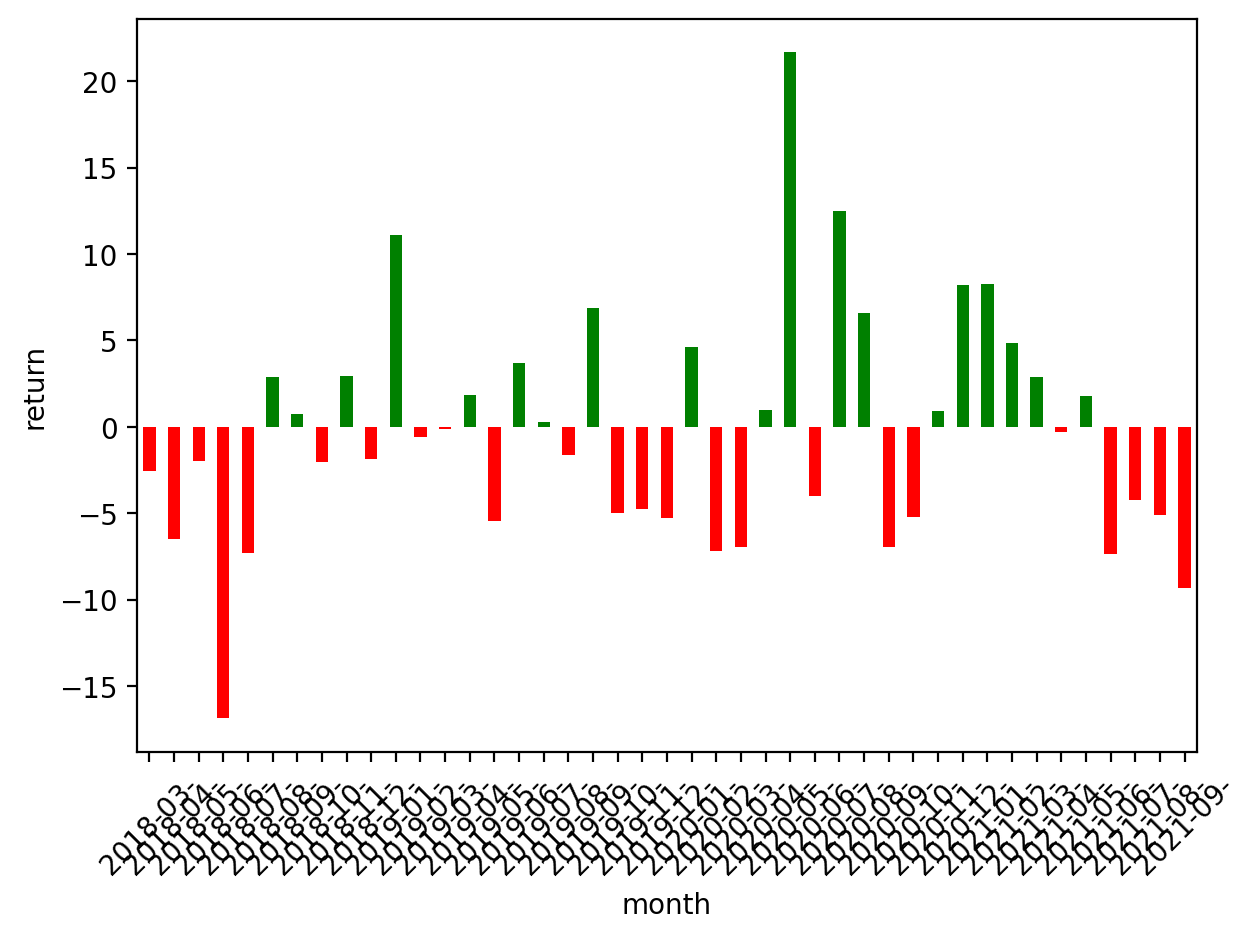

#### MAE/MFE

/Users/yassinelaraki/anaconda3/envs/PSC/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


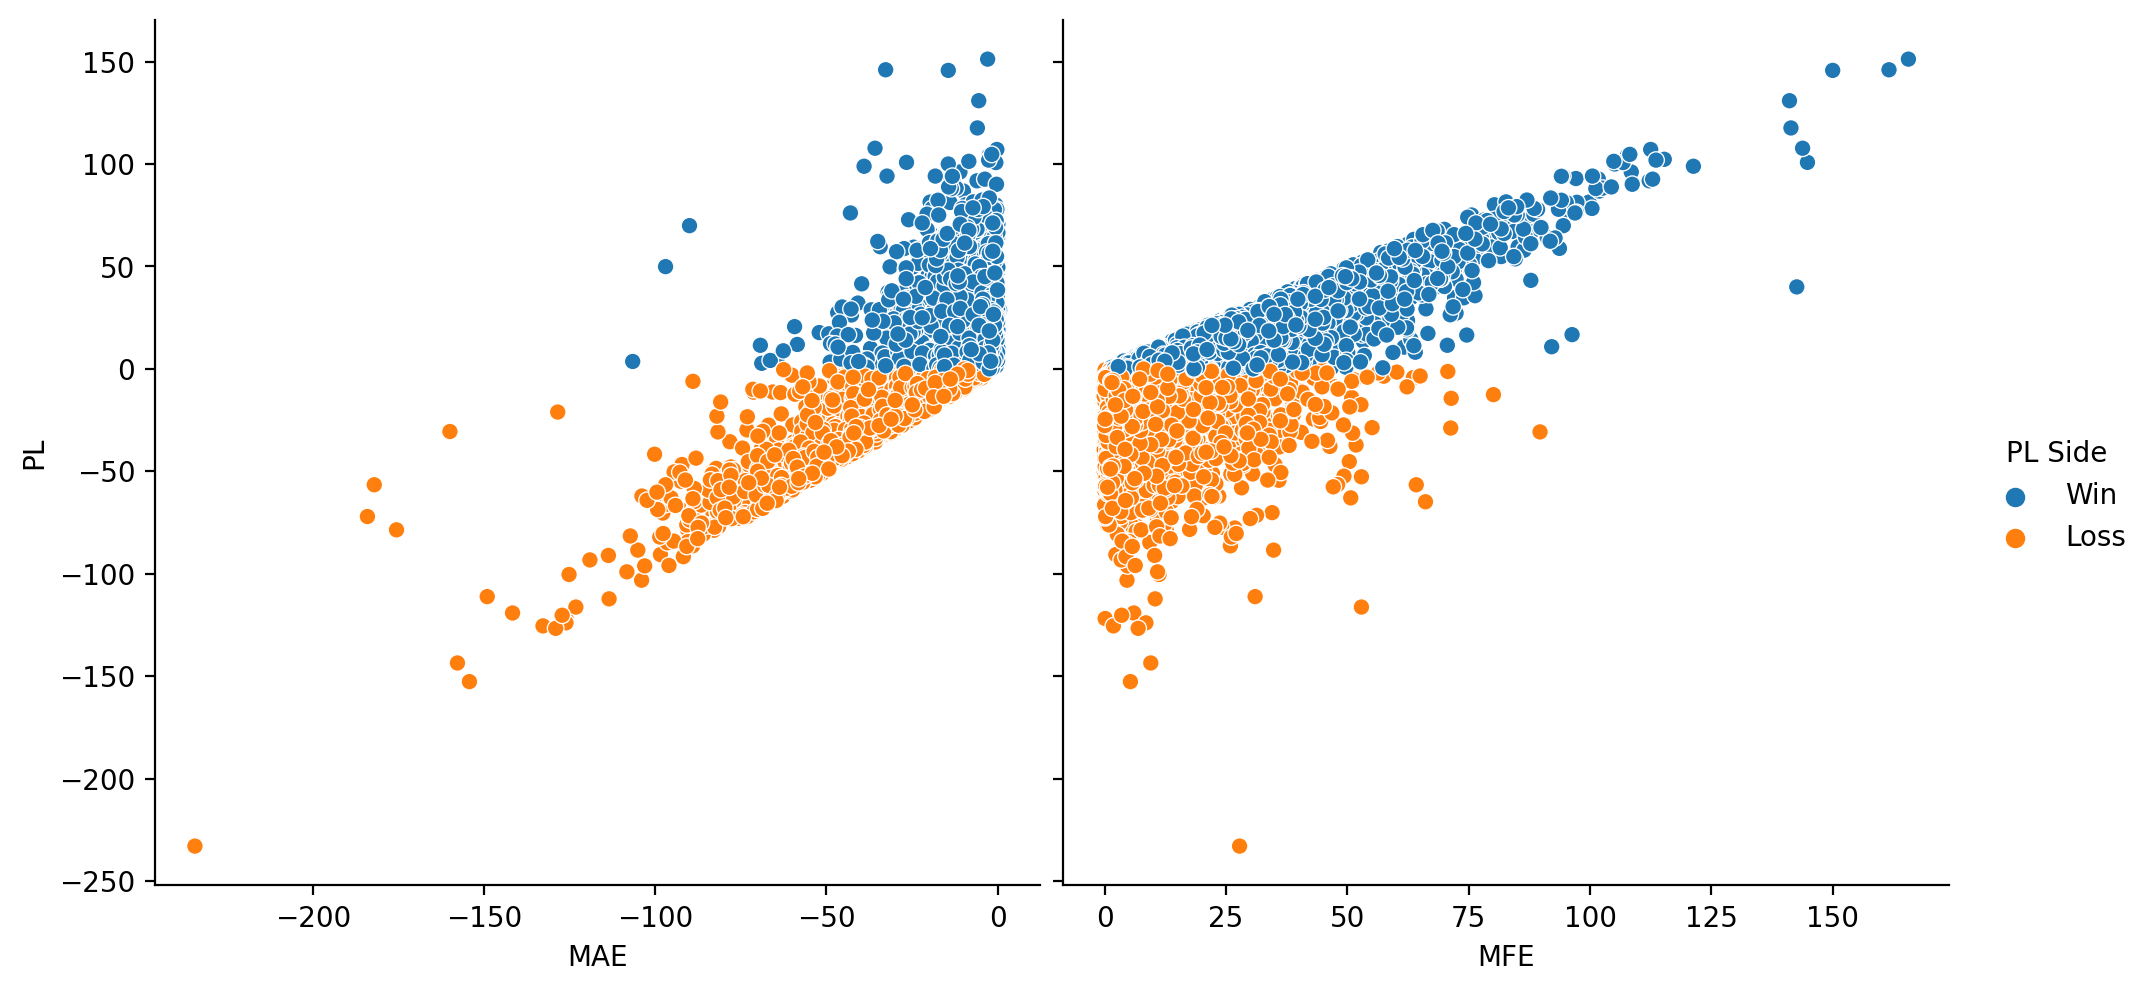

#### Trades

,Side,EntryPrice,EntryTime,ExitPrice,ExitTime,PointPL,TradeSize,PL,CumPL,Equity,Return,CumReturn,PLSign,MAE,MFE
date,,,,,,,,,,,,,,,
2018-03-27 12:00:00,SELL,1.24064,2018-03-27 12:00:00,1.23996,2018-03-27 20:00:00,0.00068,"10,000",6.8,6.8,10006.8,0.000680,0.00068,1,-9.0,34.8
2018-03-27 13:00:00,SELL,1.23906,2018-03-27 13:00:00,1.23959,2018-03-27 21:00:00,-0.00053,"10,000",-5.3,1.5,10001.5,-0.000530,0.00015,-1,-24.8,19.0
2018-03-27 14:00:00,SELL,1.23864,2018-03-27 14:00:00,1.24016,2018-03-27 22:00:00,-0.00152,"10,000",-15.2,-13.7,9986.3,-0.001520,-0.00137,-1,-29.0,9.5
2018-03-27 15:00:00,SELL,1.23900,2018-03-27 15:00:00,1.24054,2018-03-27 23:00:00,-0.00154,"10,000",-15.4,-29.1,9970.9,-0.001542,-0.00291,-1,-25.4,1.2
2018-03-27 16:00:00,SELL,1.23928,2018-03-27 16:00:00,1.24056,2018-03-28 00:00:00,-0.00128,"10,000",-12.8,-41.9,9958.1,-0.001284,-0.00419,-1,-22.6,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-24 12:00:00,SELL,1.17339,2021-09-24 12:00:00,1.17154,2021-09-24 20:00:00,0.00185,"10,000",18.5,-2160.8,7839.2,0.002366,-0.21608,1,-2.4,33.8
2021-09-24 13:00:00,SELL,1.17131,2021-09-24 13:00:00,1.17157,2021-09-24 21:00:00,-0.00026,"10,000",-2.6,-2163.4,7836.6,-0.000332,-0.21634,-1,-11.7,13.0
2021-09-24 14:00:00,SELL,1.17061,2021-09-24 14:00:00,1.17198,2021-09-24 22:00:00,-0.00137,"10,000",-13.7,-2177.1,7822.9,-0.001748,-0.21771,-1,-18.7,6.0


53/53 [==============================] - 0s 268us/step


### EURUSD Model V1 Strategy

CY

_2024-04-26 20:18:46_

#### Setup

,
symbol,EURUSD
timescale,Hourly
spread,0.00000
starting equity,"10,000"
from,2021-09-28 12:00:00
to,2023-01-10 16:00:00


---

#### Performance Report

,All,Long,Short
Net P&L,343.00,-601.40,944.40
Gross Profit,"24,704.60","13,253.40","11,451.20"
Gross Loss,"-24,361.60","-13,854.80","-10,506.80"
Profit Factor,1.01,0.96,1.09
Total # of Trades,"1,680.00",895.00,785.00
Number Winning Trades,852.00,423.00,429.00
Number Losing Trades,828.00,472.00,356.00
Percent Profitable,0.51,0.47,0.55
Avg Trade Win Loss,0.20,-0.67,1.20
Avg Winning Trade,29.00,31.33,26.69


#### Performance/Risk Metrics

,,
slope,0.9985,
r2,0.1393,
stderr,0.0606,
quality ratio,2.2943,
Max Drawdown,4389.5,2023-01-11 00:00:00
Max Drawdown %,30.0 %,2023-01-11 00:00:00


#### Returns Metrics

,
Cumulative returns,0.0343
Annual return,0.0256
Average monthly return,0.0039
Return Max Drawdown,-0.2964
MDD Recovery Period,0.0000
Longest Drawdown Period,104.0000
Mean daily loss,-0.0076
Worst daily loss,-0.0513
99% quantile daily loss,-0.0377
Worst monthly loss,-0.1430


#### Risk Adjusted Metrics

,
Sharpe,0.1459
Sortino,0.2045
Omega,1.0425
Calmar,0.0864


#### Equity Curve

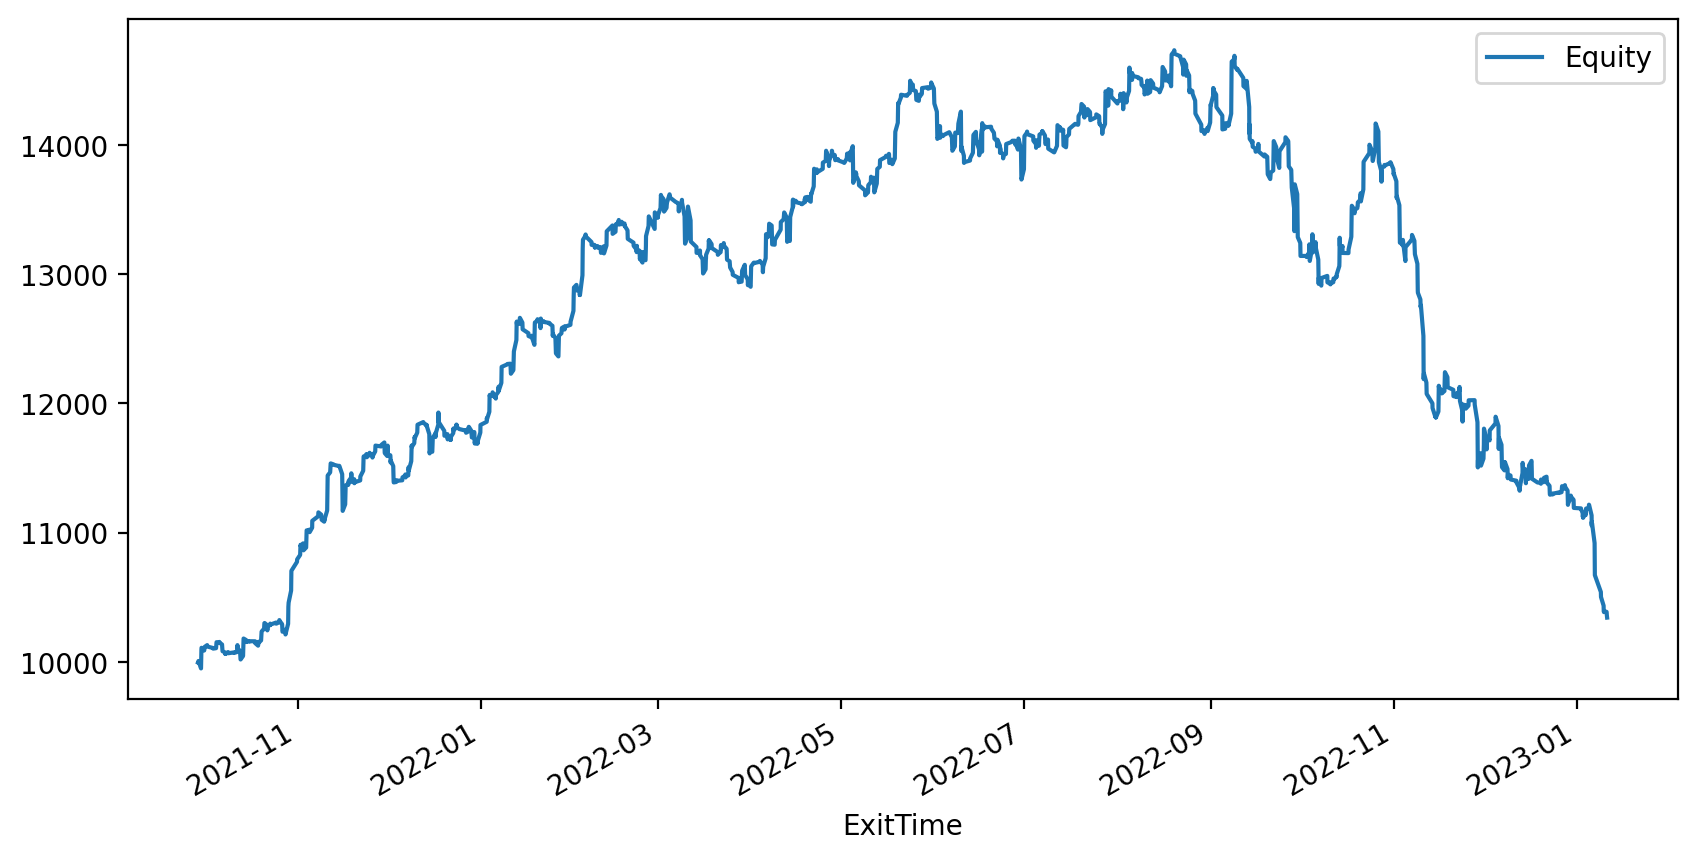

#### P&L Statistics

,Daily PL,Weekly PL,Monthly PL
count,336.00,68.00,17.00
mean,1.02,5.04,20.18
std,135.81,345.89,834.24
min,-565.20,"-1,302.30","-2,097.90"
25%,-63.68,-101.20,-438.30
50%,2.35,44.35,184.40
75%,68.42,221.80,645.70
max,437.90,810.00,"1,018.60"


#### Monthly Returns

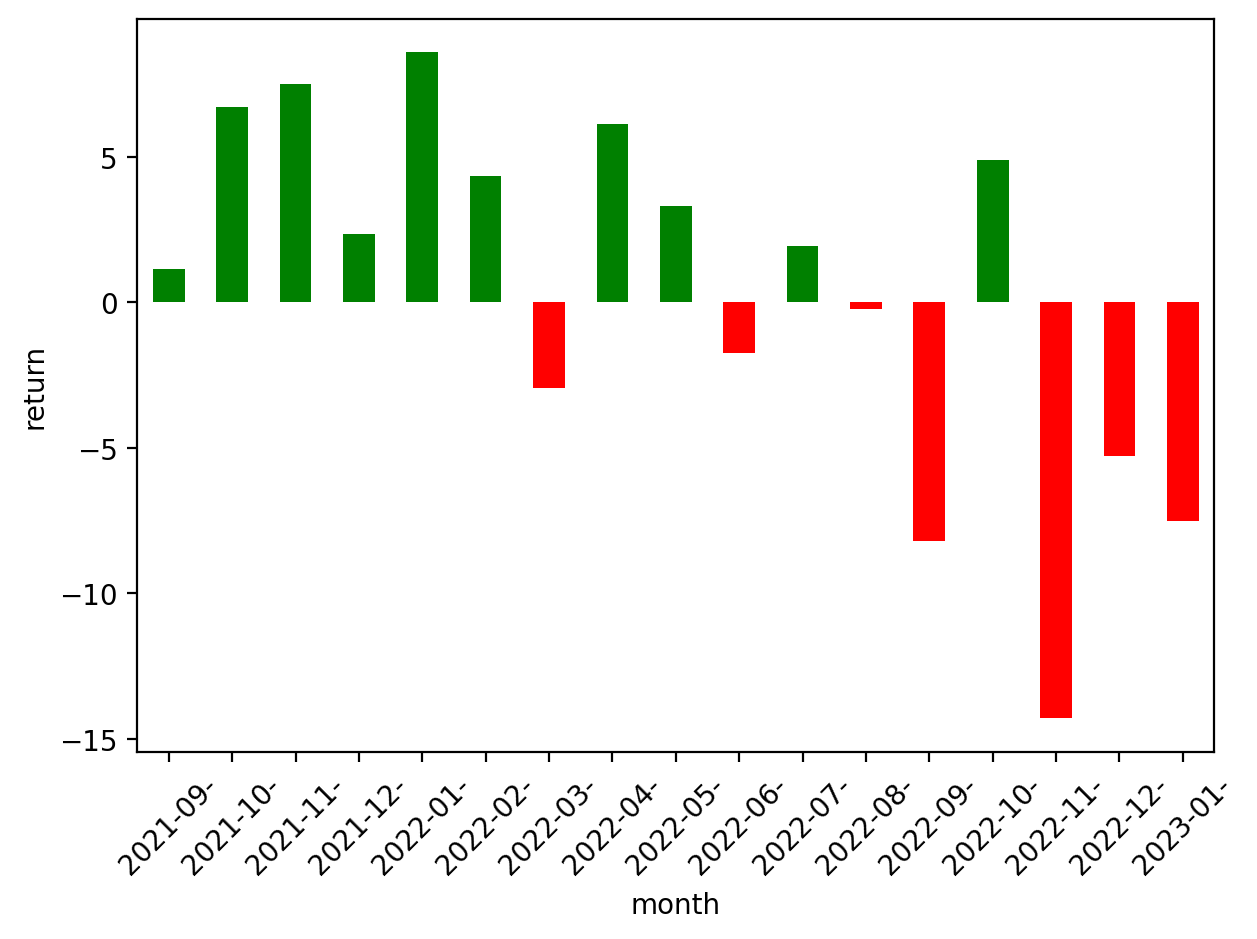

#### MAE/MFE

/Users/yassinelaraki/anaconda3/envs/PSC/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


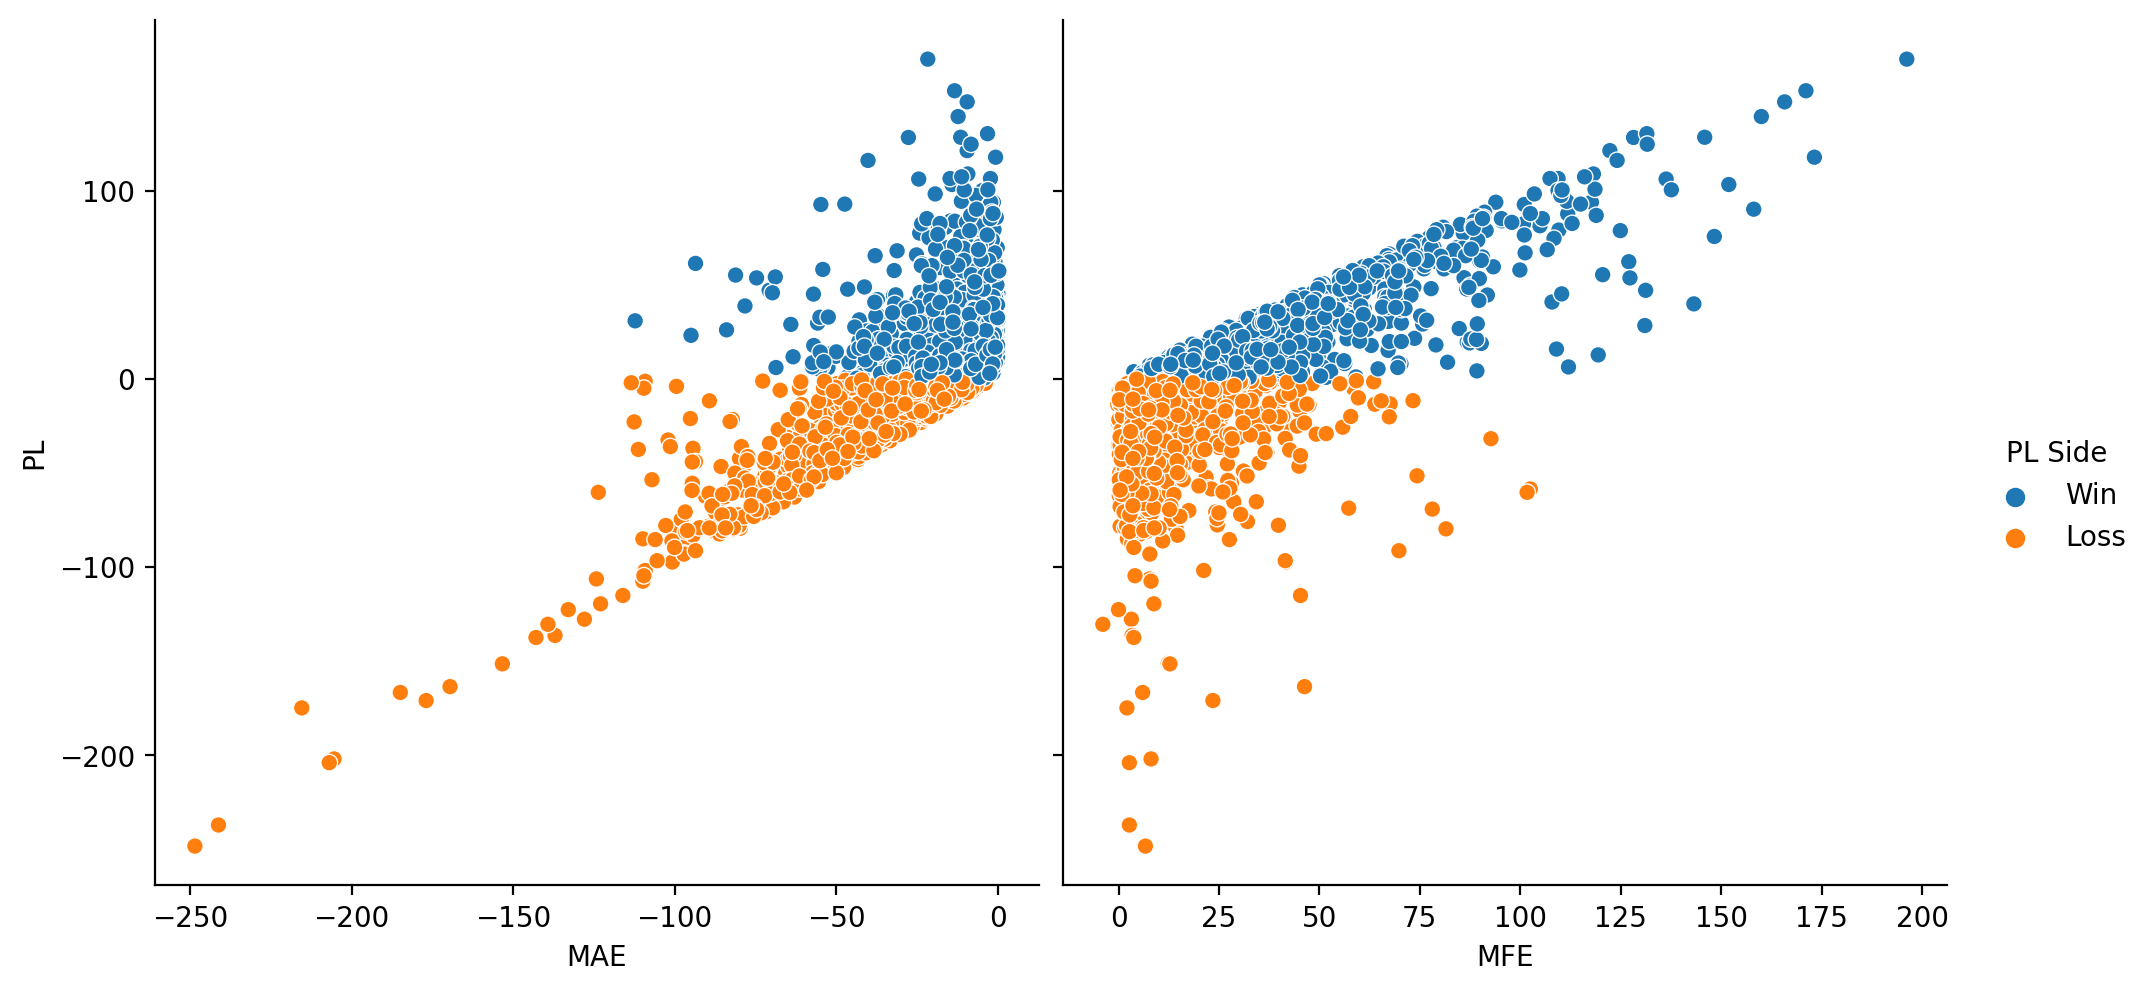

#### Trades

,Side,EntryPrice,EntryTime,ExitPrice,ExitTime,PointPL,TradeSize,PL,CumPL,Equity,Return,CumReturn,PLSign,MAE,MFE
date,,,,,,,,,,,,,,,
2021-09-28 12:00:00,BUY,1.16811,2021-09-28 12:00:00,1.16765,2021-09-28 20:00:00,-0.00046,"10,000",-4.6,-4.6,9995.4,-0.000460,-0.00046,-1,-13.6,19.5
2021-09-28 13:00:00,SELL,1.16867,2021-09-28 13:00:00,1.16847,2021-09-28 21:00:00,0.00020,"10,000",2.0,-2.6,9997.4,0.000200,-0.00026,1,-13.9,19.2
2021-09-28 14:00:00,SELL,1.16799,2021-09-28 14:00:00,1.16827,2021-09-28 22:00:00,-0.00028,"10,000",-2.8,-5.4,9994.6,-0.000280,-0.00054,-1,-20.7,12.4
2021-09-28 15:00:00,BUY,1.16804,2021-09-28 15:00:00,1.16821,2021-09-28 23:00:00,0.00017,"10,000",1.7,-3.7,9996.3,0.000170,-0.00037,1,-12.9,20.2
2021-09-28 16:00:00,BUY,1.16732,2021-09-28 16:00:00,1.16845,2021-09-29 00:00:00,0.00113,"10,000",11.3,7.6,10007.6,0.001130,0.00076,1,-5.7,16.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-10 12:00:00,SELL,1.07351,2023-01-10 12:00:00,1.07408,2023-01-10 20:00:00,-0.00057,"10,000",-5.7,387.5,10387.5,-0.000548,0.03875,-1,-24.3,23.2
2023-01-10 13:00:00,SELL,1.07194,2023-01-10 13:00:00,1.07359,2023-01-10 21:00:00,-0.00165,"10,000",-16.5,371.0,10371.0,-0.001588,0.03710,-1,-40.0,7.5
2023-01-10 14:00:00,SELL,1.07218,2023-01-10 14:00:00,1.07329,2023-01-10 22:00:00,-0.00111,"10,000",-11.1,359.9,10359.9,-0.001070,0.03599,-1,-37.6,0.2


In [67]:
ClassifierReport(X_val,y_val,model,history,save_best_model, batch_size=batch_size)
## Backtest on val + test set
val_test_report = bt.classifier_backtest(df,                               
                        np.concatenate([model.predict(X_val),model.predict(X_test)]),
                        y_datetime[X_train.shape[0]:],
                        predict_bars=horizon,
                        bh = False,
                        qty=10000,
                        spread = 0.0000,
                        starting_equity=10000,
                        symbol=pair,
                        side='both',
                        name='{} Model V1'.format(pair),
                        author='CY',
                        note=None,
                        showequitycurve=True,
                        showtrades=True,
                        showplstats=True,
                        showmaemfe=True)


## Backtest on backtest set
BT_report = bt.classifier_backtest(df,                               
                        model.predict(X_bck),
                        y_bck_datetime,
                        predict_bars=horizon,
                        bh = False,
                        qty=10000,
                        spread = 0.0000,
                        starting_equity=10000,
                        symbol=pair,
                        side='both',
                        name='{} Model V1'.format(pair),
                        author='CY',
                        note=None,
                        showequitycurve=True,
                        showtrades=True,
                        showplstats=True,
                        showmaemfe=True)


##############################################################################################################

train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
training_time = datetime.timedelta(seconds = callbacks[1].train_stop - callbacks[1].train_start)
best_acc_epoch = callbacks[0].best_epoch

val_test_PL = val_test_report['performance_report'].loc['Net P&L']['All']
val_test_nb_long_trades = val_test_report['performance_report'].loc['Total # of Trades']['Long']
val_test_nb_short_trade = val_test_report['performance_report'].loc['Total # of Trades']['Short']
val_test_sharpe = val_test_report['risk_adjusted_metrics']['Sharpe'][0]
val_test_sortino = val_test_report['risk_adjusted_metrics']['Sortino'][0]
val_test_max_drawdown = val_test_report['performance_risk_metrics']['Max Drawdown %'][0]

BT_PL =  BT_report['performance_report'].loc['Net P&L']['All']
BT_nb_long_trades = BT_report['performance_report'].loc['Total # of Trades']['Long']
BT_nb_short_trade= BT_report['performance_report'].loc['Total # of Trades']['Short']
BT_sharpe= BT_report['risk_adjusted_metrics']['Sharpe'][0]
BT_sortino = BT_report['risk_adjusted_metrics']['Sortino'][0]
BT_max_drawdown = BT_report['performance_risk_metrics']['Max Drawdown %'][0]

# df_results.loc[len(df_results)] = model_params.values()